# 개, 고양이 분류기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

### 데이터 확인

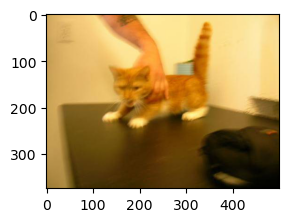

In [4]:
cat_img = Image.open('./cats_and_dogs_filtered/train/cats/cat.0.jpg')

plt.figure(figsize=(3, 3))
plt.imshow(cat_img)
plt.show()

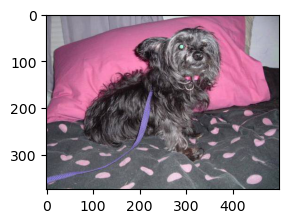

In [5]:
dog_img = Image.open('./cats_and_dogs_filtered/train/dogs/dog.0.jpg')

plt.figure(figsize=(3, 3))
plt.imshow(dog_img)
plt.show()

TypeError: Invalid shape (3, 374, 500) for image data

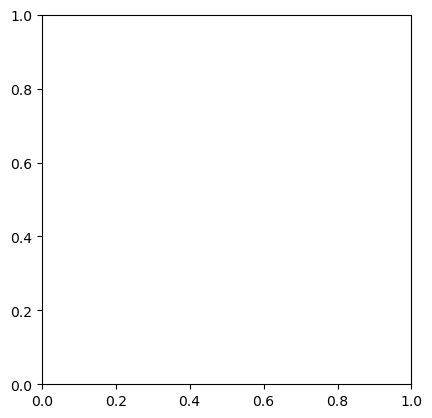

In [6]:
# 이미지 데이터의 형태 확인
# torchvision.transforms를 사용하여 tensor형태로 변환

transform = T.Compose([
    T.ToTensor()
])

cat_tensor = transform(cat_img)
cat_tensor.shape
plt.imshow(cat_tensor) # 오류 발생 -> imshow는 (height, width, cahnnel)형태가 필요

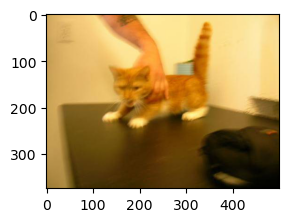

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(cat_tensor.permute(1, 2, 0)) # channel값을 뒤로 이동시켜 imshow 수행
plt.show()

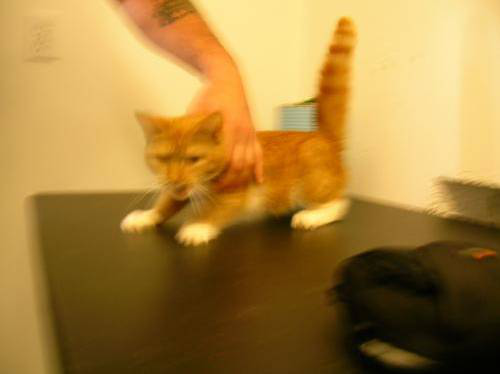

In [8]:
Image.open('./cats_and_dogs_filtered/train/cats/cat.0.jpg')

In [9]:
to_tensor = torchvision.transforms.ToTensor()
to_tensor(Image.open('./cats_and_dogs_filtered/train/cats/cat.0.jpg'))

tensor([[[0.7961, 0.7961, 0.8000,  ..., 0.9412, 0.9373, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9373],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.0078, 0.0078, 0.0078],
         [0.5961, 0.5961, 0.5961,  ..., 0.0078, 0.0078, 0.0078],
         [0.5922, 0.5922, 0.5922,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.6431, 0.6431, 0.6471,  ..., 0.7882, 0.7843, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7843],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.0078, 0.0078, 0.0078],
         [0.4745, 0.4745, 0.4745,  ..., 0.0078, 0.0078, 0.0078],
         [0.4706, 0.4706, 0.4706,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.3412, 0.3412, 0.3451,  ..., 0.4784, 0.4745, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.

# CustomDataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    # 데이터를 전부 하나의 변수에 저장한다.
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir # 데이터 기본 경로
        self.transform = transform # tensor로 변환 함수
        self.classes = ['cats', 'dogs'] # 데이터의 클래스
        self.images = [] # 이미지 데이터의 경로 저장 -> 데이터를 저장하는 것과 동일하다. -> __getitem__에서 경로를 통해 데이터를 실제로 가져온다.

        # label: 클래스를 0과 1으로 표현하는 것을 구현한 것
        # cls: 각 클래스 이름 -> 데이터 경로에 사용
        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            img_list = os.listdir(class_dir) # 모든 이미지 경로를 가져온다.
            for img in img_list:
                self.images.append((os.path.join(class_dir, img), label)) # 이미지, 라벨을 튜플로 묶어서 추가한다.

    # 데이터의 크기를 반환한다.
    def __len__(self):
        return len(self.images)
    
    # 특정 위치의 값을 하나 반환한다.
    def __getitem__(self, idx):
        img_path, label = self.images[idx] # idx위치의 데이터를 꺼낸다.
        img_tmp = Image.open(img_path).convert('RGB') # 이미지를 실제로 오픈한다. -> convert('RGB'): 이미지의 채널이 다른 경우가 있을 수 있기에 모든 채널을 3채널으로 맞춰주기 위함
        img = self.transform(img_tmp) # 이미지를 tensor형태로 바꿔준다.

        return img, label

In [11]:
train_root_dir = './cats_and_dogs_filtered/train'
test_root_dir = './cats_and_dogs_filtered/validation'

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = CustomDataset(root_dir=train_root_dir, transform=transform)
test_dataset = CustomDataset(root_dir=test_root_dir, transform=transform)

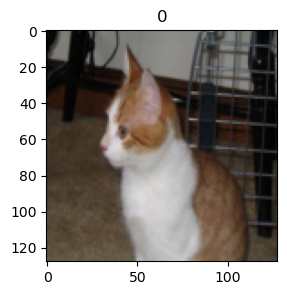

In [12]:
# 데이터 확인

plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.title(train_dataset[0][1])
plt.show()

In [13]:
# train, valid 데이터 분할

total_size = len(train_dataset)
train_num, valid_num = int(total_size*0.8), int(total_size*0.2)

print("Train dataset 개수:", train_num)
print("Validation dataset 개수:", valid_num)
print('Test dataset 개수:', len(test_dataset))

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

Train dataset 개수: 1600
Validation dataset 개수: 400
Test dataset 개수: 1000


## DataLoader

In [14]:
batch_size = 1600

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
print(len(train_dataloader))

for images, labels in train_dataloader:
    print(len(images)) # batch size
    print(images.shape) # 이미지 형태
    print(labels) # 현재 가져온 데이터에서 라벨
    break

1
1600
torch.Size([1600, 3, 128, 128])
tensor([0, 0, 1,  ..., 1, 0, 1])


# Model 생성
- 간단한 모델에서 시작하여 점점 복잡한 모델 구성

In [16]:
# 가장 간단한 모델
class CNN_v1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=128*128*32, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=256),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=256, out_features=2),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [17]:
model = CNN_v1()
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
           Flatten-9               [-1, 524288]               0
           Linear-10                 [-1, 1024]     536,871,936
             ReLU-11                 [-1, 1024]               0
           Linear-12                  [-1, 256]         262,400
             ReLU-13                  [-1, 256]               0
           Linear-14                   

### train, evaluation 함수

In [18]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, device):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        print(epoch)
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, device)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [19]:
model1 = CNN_v1()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
device = torch.device("mps")

model = training_loop(model1, train_dataloader, valid_dataloader, train_dataset ,valid_dataset, criterion, optimizer, 1, device)

0


  0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 13.23 GB, other allocations: 2.28 GB, max allowed: 18.13 GB). Tried to allocate 3.12 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

### test 함수

In [22]:
def testing(model, test_dataloader, test_dataset, criterion):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0
    total_label = []
    total_pred = []

    with torch.no_grad():
        tbar = tqdm(test_dataloader)
        for images, labels in tbar:
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            test_accuracy += (predicted == labels).sum().item()

            total_label.extend(labels)
            total_pred.extend(predicted)

    test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_accuracy / len(test_dataset)

    return test_loss, test_accuracy, total_label, total_pred

In [83]:
test_loss, test_accuracy, total_label, total_pred = testing(model, test_dataloader, test_dataset, criterion)
print(test_loss, test_accuracy)

plt.figure(figsize=(20, 20))

for i in range(20, 40):
    image_tmp = test_dataset[i][0].squeeze().numpy()
    image = np.transpose(image_tmp, (1, 2, 0))
    pred_label = total_pred[i]
    true_label = total_label[i]

    ax = plt.subplot(4, 5, (i%20)+1)
    plt.imshow(image)
    plt.title(f'true: {true_label}\npre: {pred_label}')

  0%|          | 0/32 [00:00<?, ?it/s]

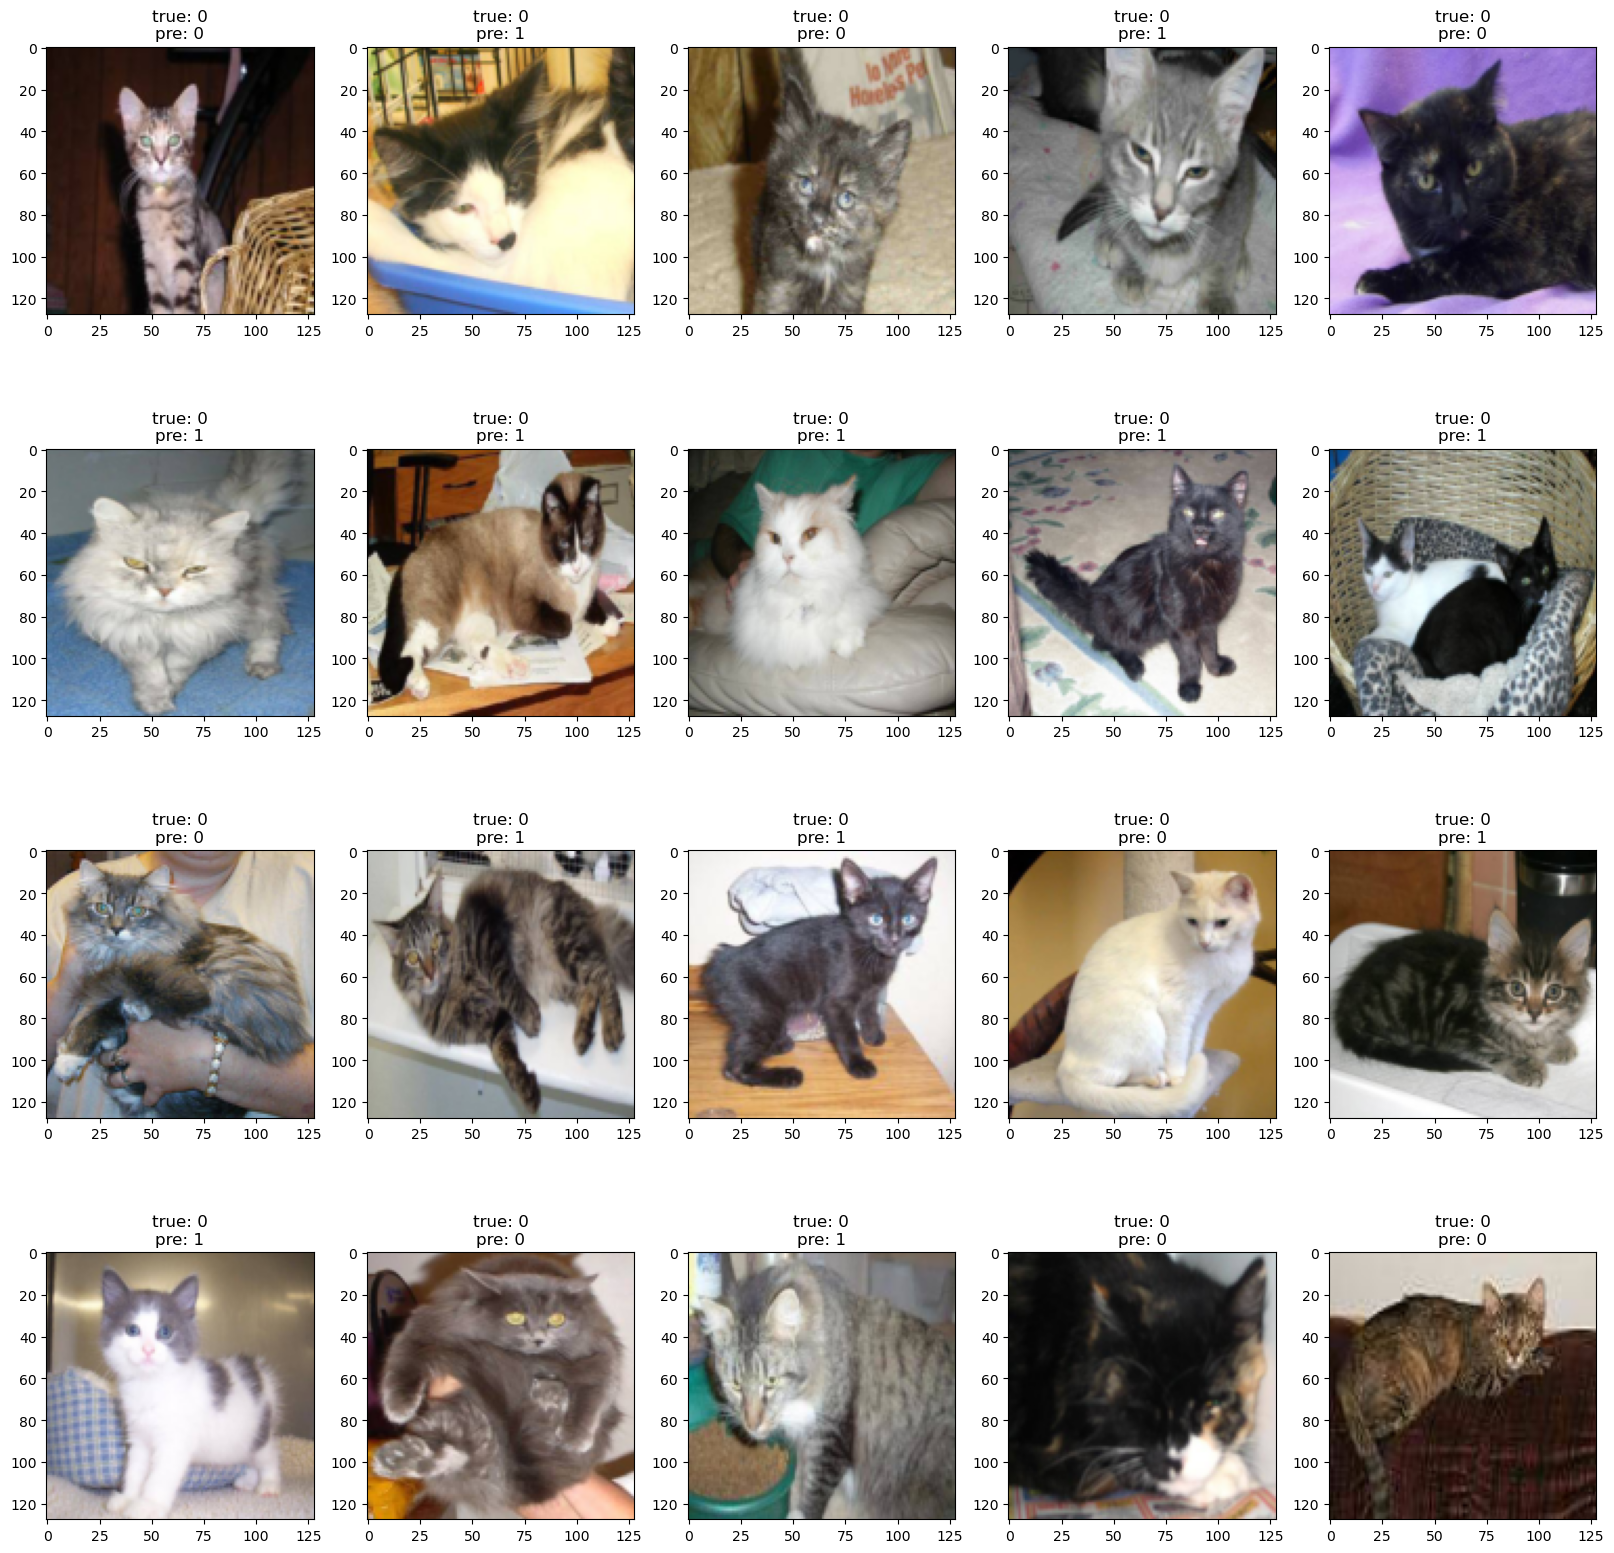

In [85]:
plt.figure(figsize=(20, 20))

for i in range(20, 40):
    image_tmp = test_dataset[i][0].squeeze().numpy()
    image = np.transpose(image_tmp, (1, 2, 0))
    pred_label = total_pred[i]
    true_label = total_label[i]

    ax = plt.subplot(4, 5, (i%20)+1)
    plt.imshow(image)
    plt.title(f'true: {true_label}\npre: {pred_label}')

### 학습 횟수 추가

In [23]:
model1 = CNN_v1()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

model = trainig_loop(model1, train_dataloader, valid_dataloader, train_dataset ,valid_dataset, criterion, optimizer, 10)

0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 327.89592724323273, Train Accuracy: 0.501875
Valid Loss: 57.09485626220703, Valid Accuracy: 0.5175
1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 5.461971398591995, Train Accuracy: 0.6025
Valid Loss: 1.5494449505439172, Valid Accuracy: 0.625
2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 1.251845030784607, Train Accuracy: 0.616875
Valid Loss: 0.9888527714289151, Valid Accuracy: 0.635
3


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/32 [00:00<?, ?it/s]

0.8671955009922385 0.627


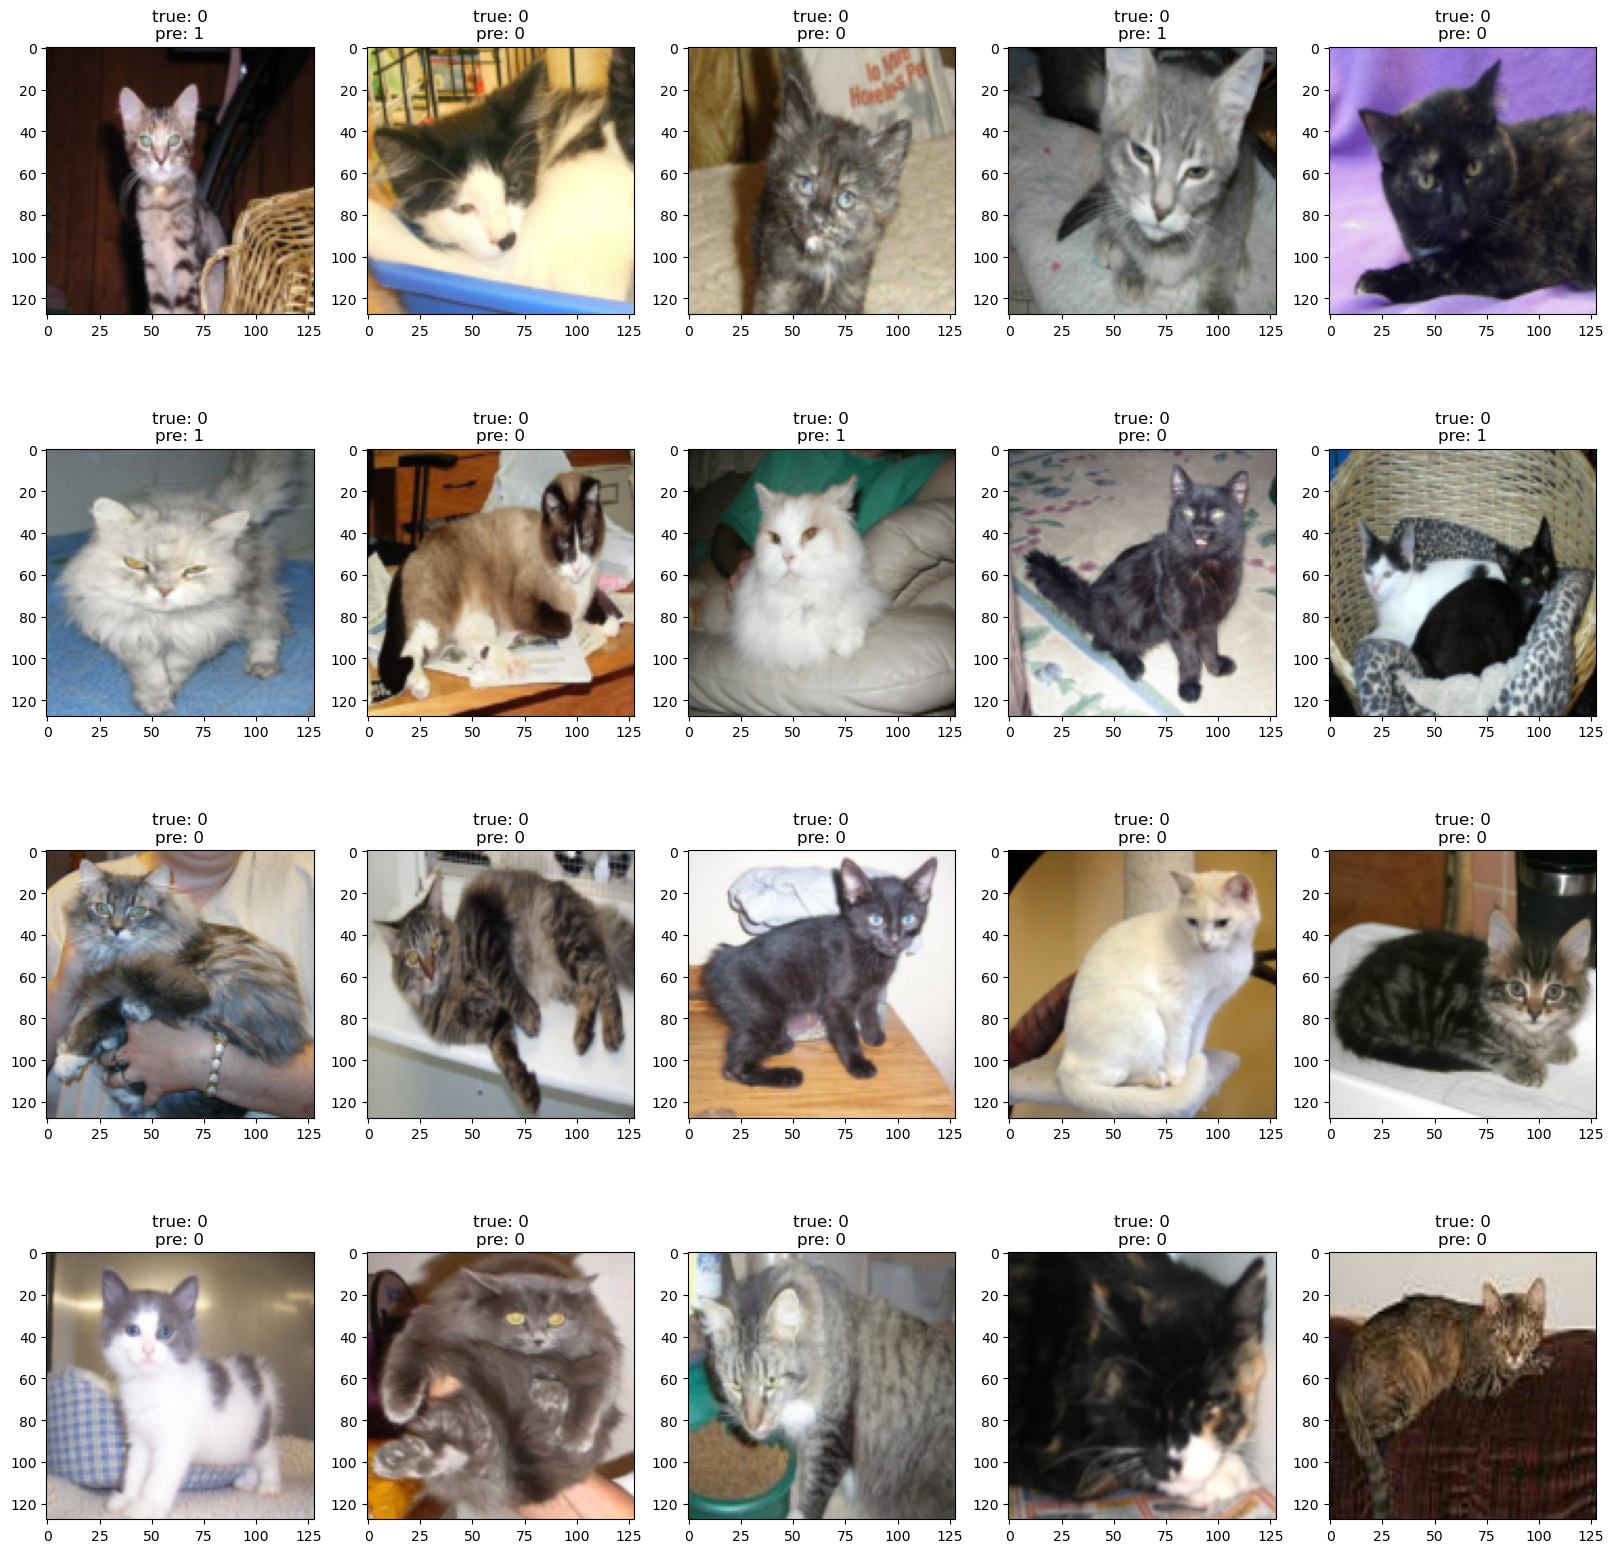

In [24]:
test_loss, test_accuracy, total_label, total_pred = testing(model1, test_dataloader, test_dataset, criterion)
print(test_loss, test_accuracy)

plt.figure(figsize=(20, 20))

for i in range(20, 40):
    image_tmp = test_dataset[i][0].squeeze().numpy()
    image = np.transpose(image_tmp, (1, 2, 0))
    pred_label = total_pred[i]
    true_label = total_label[i]

    ax = plt.subplot(4, 5, (i%20)+1)
    plt.imshow(image)
    plt.title(f'true: {true_label}\npre: {pred_label}')